# Working with Sagemaker Pipelines 

- [Overview](#overview)
- [Build the pipeline components](#build-the-pipeline-components)
   1. [Import statements and declare parameters and constants](#import-statements-and-declare-parameters-and-constants)
   2. [Collect and prepare data](#collect-and-prepare-data)
   3. [Define Processing Step](#define-processing-step)
   4. [Define HyperParameter Tuning  Step](#define-hyperparameter-tuning-step)
   5. [Define the evaluation script and model evaluation step](#define-the-evaluation-script-and-model-evaluation-step)
   6. [Define a register model step](#define-a-register-model-step)
   7. [Define a condition step to check AUC score](#define-a-condition-step-to-check-auc-score)
- [Build and Trigger the pipeline run](#build-and-trigger-the-pipeline-run)

## Overview

The following diagram illustrates the high-level architecture of the ML workflow with the different steps to train the model.

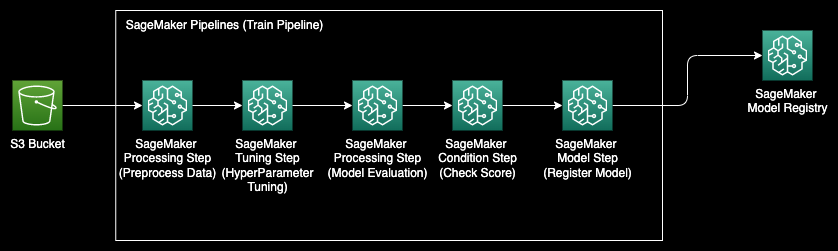

Train Pipeline consists of the following steps:

1. Preprocess data to build features required and split data into train, validation, and test datasets.
2. Apply hyperparameter tuning based on the ranges provided with the SageMaker XGBoost framework to give the best model, which is determined based on AUC score.
3. Evaluate the trained model using the test dataset and check if the AUC score is above a predefined threshold.
4. Check if the AUC score is greater than the threshold, if true register the model into SageMaker model registry.

## Build the pipeline components

### Step 1: Import statements and declare parameters and constants

In [5]:
!pip install --upgrade boto3

  Using cached boto3-1.27.1-py3-none-any.whl (135 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 45.5 MB/s eta 0:00:0000:0100:01
  Using cached s3transfer-0.6.1-py3-none-any.whl (79 kB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.21
    Uninstalling botocore-1.24.21:
      Successfully uninstalled botocore-1.24.21
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.5.2
    Uninstalling s3transfer-0.5.2:
      Successfully uninstalled s3transfer-0.5.2
  Attempting uninstall: boto3
    Found existing installation: boto3 1.21.21
    Uninstalling boto3-1.21.21:
      Successfully uninstalled boto3-1.21.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.3.0 requires botocore<1.24.22,>=1.24.21, but you have botocore 1.30.1 which is incompatible.
awscli 1.22.76 requires boto

In [1]:
import boto3 
import pandas as pd 
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession 

s3_client = boto3.resource('s3') 
pipeline_name = f"sagemaker-mlops-train-pipeline" 
import sagemaker
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name 
role = sagemaker.get_execution_role() 
pipeline_session = PipelineSession() 
default_bucket = sagemaker_session.default_bucket() 
model_package_group_name = f"ChurnModelPackageGroup"

In [3]:
from sagemaker.workflow.parameters import ( 
 ParameterInteger, 
 ParameterString, 
 ParameterFloat) 

auc_score_threshold = 0.75 
base_job_prefix = "churn-example"
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
processing_instance_type = ParameterString( name="ProcessingInstanceType", default_value="ml.m5.xlarge") 
training_instance_type = ParameterString( name="TrainingInstanceType", default_value="ml.m5.xlarge") 
input_data = "storedata_total.csv" 
model_approval_status = ParameterString( name="ModelApprovalStatus", default_value="PendingManualApproval")

### Step 2: Collect and prepare data

In [4]:
!wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/dataset/storedata_total.xlsx

--2023-07-06 16:36:54--  https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/dataset/storedata_total.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2713209 (2.6M) [application/octet-stream]
Saving to: ‘storedata_total.xlsx’

storedata_total.xls 100%[===================>]   2.59M  --.-KB/s    in 0.02s   

2023-07-06 16:36:54 (138 MB/s) - ‘storedata_total.xlsx’ saved [2713209/2713209]



In [5]:
store_data = pd.read_excel("storedata_total.xlsx") 
store_data.to_csv("storedata_total.csv")

/opt/conda/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Step 3: Define Processing Step

In [6]:
!wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/preprocess-churn.py

--2023-07-06 16:37:46--  https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/preprocess-churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2156 (2.1K) [text/plain]
Saving to: ‘preprocess-churn.py’

preprocess-churn.py 100%[===================>]   2.11K  --.-KB/s    in 0s      

2023-07-06 16:37:47 (36.3 MB/s) - ‘preprocess-churn.py’ saved [2156/2156]



In [7]:
!pygmentize "preprocess-churn.py"

import os
import tempfile
import numpy as np
import pandas as pd
import datetime as dt
if __name__ == "__main__":
    base_dir = "/opt/ml/processing"
    #Read Data
    df = pd.read_csv(
        f"{base_dir}/input/storedata_total.csv"
    )
    # convert created column to datetime
    df["created"] = pd.to_datetime(df["created"])
    #Convert firstorder and lastorder to datetime datatype
    df["firstorder"] = pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    #Drop Rows with Null Values
    df = df.dropna()
    #Create column which gives the days between the last order and the first order
    df['first_last_days_diff'] = (df['lastorder'] - df['firstorder']).dt.days
    #Create column which gives the days between the customer record was created and the first order
    df['created_first_days_diff'] = (df['created'] - df['firstorder']).dt.days
    #Drop columns
    df.drop(['custid', 'created','firstorder','lastorder

In [8]:
input_data

'storedata_total.csv'

In [9]:
# Define Processing Step for Feature Engineering
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

framework_version = "1.0-1"
sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=processing_instance_count,
    base_job_name="sklearn-churn-process",
    role=role,
    sagemaker_session=pipeline_session,
)
processor_args = sklearn_processor.run(
    inputs=[
      ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),  
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train",\
                         destination=f"s3://{default_bucket}/output/train" ),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation",\
                        destination=f"s3://{default_bucket}/output/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test",\
                        destination=f"s3://{default_bucket}/output/test")
    ],
    code=f"preprocess-churn.py",
)
step_process = ProcessingStep(name="ChurnModelProcess", step_args=processor_args)

/opt/conda/lib/python3.7/site-packages/sagemaker/workflow/pipeline_context.py:289: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  UserWarning,


### Step 4: Define HyperParameter Tuning  Step

In [10]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.workflow.steps import TuningStep

model_path = f"s3://{default_bucket}/output"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)
fixed_hyperparameters = {
"eval_metric":"auc",
"objective":"binary:logistic",
"num_round":"100",
"rate_drop":"0.3",
"tweedie_variance_power":"1.4"
}
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    output_path=model_path,
    base_job_name=f"churn-train",
    sagemaker_session=pipeline_session,
    role=role,
)

The input argument instance_type of function (sagemaker.image_uris.retrieve) is a pipeline variable (<class 'sagemaker.workflow.parameters.ParameterString'>), which is not allowed. The default_value of this Parameter object will be used to override it. Please make sure the default_value is valid.


In [11]:
hyperparameter_ranges = {
"eta": ContinuousParameter(0, 1),
"min_child_weight": ContinuousParameter(1, 10),
"alpha": ContinuousParameter(0, 2),
"max_depth": IntegerParameter(1, 10),
}
objective_metric_name = "validation:auc"

tuner = HyperparameterTuner(
    xgb_train,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=2,
    max_parallel_jobs=2,
)

hpo_args = tuner.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

step_tuning = TuningStep(
    name="ChurnHyperParameterTuning",
    step_args=hpo_args,
)

### Step 5: Define the evaluation script and model evaluation step

In [12]:
!wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/evaluate-churn.py

--2023-07-06 16:49:24--  https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/evaluate-churn.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309 (1.3K) [text/plain]
Saving to: ‘evaluate-churn.py’

evaluate-churn.py   100%[===================>]   1.28K  --.-KB/s    in 0s      

2023-07-06 16:49:24 (38.4 MB/s) - ‘evaluate-churn.py’ saved [1309/1309]



In [14]:
!pygmentize "evaluate-churn.py"

import json
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost
import datetime as dt
from sklearn.metrics import roc_curve,auc
if __name__ == "__main__":   
    #Read Model Tar File
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    model = pickle.load(open("xgboost-model", "rb"))
    #Read Test Data using which we evaluate the model
    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)
    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)
    X_test = xgboost.DMatrix(df.values)
    #Run Predictions
    predictions = model.predict(X_test)
    #Evaluate Predictions
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    auc_score = auc(fpr, tpr)
    report_dict = {
        "classification_metrics": {
            "auc_score": {
                "value": auc_score,


In [15]:
# define model evaluation step to evaluate the trained model
from sagemaker.processing import ScriptProcessor
script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="script-churn-eval",
    role=role,
    sagemaker_session=pipeline_session,
)
eval_args = script_eval.run(
     inputs=[
            ProcessingInput(
                source=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=default_bucket,prefix="output"),
                destination="/opt/ml/processing/model"
            ),
            ProcessingInput(
                source=step_process.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test"
            )
        ],
    outputs=[
            ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation",\
                             destination=f"s3://{default_bucket}/output/evaluation"),
        ],
    code=f"evaluate-churn.py",
)
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="ChurnEvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="ChurnEvalModel",
    step_args=eval_args,
    property_files=[evaluation_report],
)

### Step 6: Define a register model step

In [16]:
from sagemaker import Model
from sagemaker.workflow.model_step import ModelStep

model = Model(
    image_uri=image_uri,
    model_data=step_tuning.get_top_model_s3_uri(top_k=0,s3_bucket=default_bucket,prefix="output"),
    sagemaker_session=pipeline_session,
    role=role,
)
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)
register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name="ChurnRegisterModel", step_args=register_args)

### Step 7: Define a condition step to check AUC score

In [17]:
from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet
cond_lte = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="classification_metrics.auc_score.value",
    ),
    right=auc_score_threshold,
)
step_cond = ConditionStep(
    name="CheckAUCScoreChurnEvaluation",
    conditions=[cond_lte],
    if_steps=[step_register],
)

## Build and Trigger the pipeline run

After defining all of the component steps, you can assemble them into a Pipelines object. You don’t need to specify the order of pipeline because Pipelines automatically infers the order sequence based on the dependencies between the steps.

In [18]:
import json
from sagemaker.workflow.pipeline import Pipeline

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        processing_instance_type,
        training_instance_type,
        model_approval_status,
        input_data,
        auc_score_threshold,
    ],
    steps=[step_process, step_tuning, step_eval, step_cond],
) 
definition = json.loads(pipeline.definition())
print(definition)

{'Version': '2020-12-01', 'Metadata': {}, 'Parameters': [{'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1}, {'Name': 'ProcessingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m5.xlarge'}, {'Name': 'TrainingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m5.xlarge'}, {'Name': 'ModelApprovalStatus', 'Type': 'String', 'DefaultValue': 'PendingManualApproval'}], 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'}, 'TrialName': {'Get': 'Execution.PipelineExecutionId'}}, 'Steps': [{'Name': 'ChurnModelProcess', 'Type': 'Processing', 'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.xlarge', 'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'}, 'VolumeSizeInGB': 30}}, 'AppSpecification': {'ImageUri': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.0-1-cpu-py3', 'ContainerEntrypoint': ['python3', '/opt/ml/processing/input/code/preprocess-churn.py']}, 'RoleArn': 'arn:aws:i

In [19]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=role)
# start Pipeline execution
pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:866824485776:pipeline/sagemaker-mlops-train-pipeline/execution/4tgj3dqvd9vq', sagemaker_session=<sagemaker.session.Session object at 0x7f5a18c12c90>)